In [360]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex
from scipy.optimize import least_squares

In [340]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [341]:
alpha = 3.
c1s   = np.arange(1, 20.01, 0.1)
c1s

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
       15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16

In [342]:
guesses = c1s

xTildes  = []
welfares = [] 
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
xTildes.shape, welfares.shape

((191, 2), (191,))

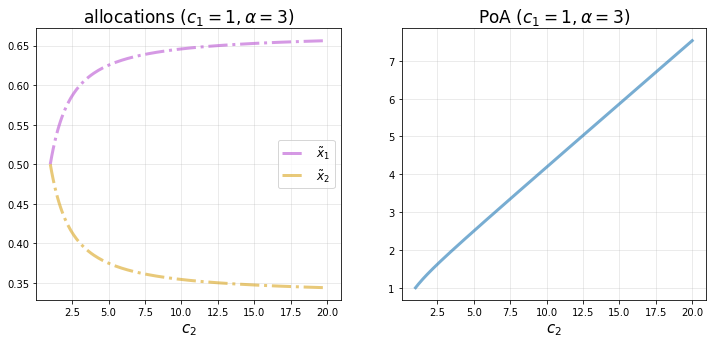

In [343]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')

axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6)

for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
axarr[0].legend(prop={'size': 12})
axarr[0].set_title(r'allocations $(c_1=1, \alpha=3)$', size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha=3)$', size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [25]:
costs = [1, 5]

In [26]:
bids = getEquilBids(costs, a=alpha, guess=costs)
bids

array([ 9.03191683, 10.71104368])

In [27]:
allos = getAllos(bids, a=alpha)
allos

array([0.62516557, 0.37483443])

In [31]:
sc = np.dot(costs, allos)
sc

2.4993377083378556

# sympy for diff for PoA

In [497]:
b0 = sp.Symbol('b0', positive=True)
R = sp.Symbol('R', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)

In [519]:
alpha=4

In [520]:
u0 = ( (b0 - 1)*b0**(-alpha) ) / ( b0**(-alpha) + R**(-alpha) )
u0

(b0 - 1)/(b0**4*(b0**(-4) + R**(-4)))

In [521]:
du0_db0 = sp.diff(u0, b0)
du0_db0

1/(b0**4*(b0**(-4) + R**(-4))) - 4*(b0 - 1)/(b0**5*(b0**(-4) + R**(-4))) + 4*(b0 - 1)/(b0**9*(b0**(-4) + R**(-4))**2)

In [522]:
foc = sp.Eq(sp.simplify(du0_db0),0)
foc

Eq(R**4*(R**4 - 3*b0**4 + 4*b0**3)/(R**8 + 2*R**4*b0**4 + b0**8), 0)

In [523]:
sols = sp.solve(foc, b0)

In [535]:
sols[3]

sqrt(6*R**(8/3)/(sqrt(R**4 + 1) - 1)**(1/3) - 6*R**(4/3)*(sqrt(R**4 + 1) - 1)**(1/3) + 8*sqrt(2)*R**(2/3)/sqrt(3*R**(8/3)*(sqrt(R**4 + 1) - 1)**(1/3) + 2*R**(4/3) - 3*R**4/(sqrt(R**4 + 1) - 1)**(1/3)) + 8)/6 + 1/3 + sqrt(6*R**(8/3)*(sqrt(R**4 + 1) - 1)**(1/3) + 4*R**(4/3) - 6*R**4/(sqrt(R**4 + 1) - 1)**(1/3))/(6*R**(2/3))

In [533]:
sols[3].evalf(subs={R:11})

8.71256618731619

In [210]:
du0_db0

-alpha*(b0 - 1)/(b0*b0**alpha*(N/R**alpha + b0**(-alpha))) + alpha*(b0 - 1)/(b0*b0**(2*alpha)*(N/R**alpha + b0**(-alpha))**2) + 1/(b0**alpha*(N/R**alpha + b0**(-alpha)))

In [211]:
eq_numeric = du0_db0.evalf(subs={alpha:4., N:1., R:2.})
eq_numeric

4.0*(b0 - 1.0)/(b0**9.0*(b0**(-4.0) + 0.0625)**2) - 4.0*(b0 - 1.0)/(b0**5.0*(b0**(-4.0) + 0.0625)) + 1/(b0**4.0*(b0**(-4.0) + 0.0625))

In [212]:
du0_db0

-alpha*(b0 - 1)/(b0*b0**alpha*(N/R**alpha + b0**(-alpha))) + alpha*(b0 - 1)/(b0*b0**(2*alpha)*(N/R**alpha + b0**(-alpha))**2) + 1/(b0**alpha*(N/R**alpha + b0**(-alpha)))

In [213]:
b0_sol = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
b0_sol

2.00000000000000

# numerical for diff for PoA

In [93]:
from scipy.optimize import brentq, newton

def u0_derivative(b0, N_, R_, alpha_):
    guess = 1
    eq_numeric = du0_db0.evalf(subs={N:1., R:2., alpha_})
    b0_sol = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
    return derivative_value

In [214]:
def getAllo(b0, N_, R_, alpha_):
    return b0**(-alpha_) / (b0**(-alpha_) + N_*R_**(-alpha_))

In [266]:
N_ = 1
R_ = 8
alpha_ = 4
guess = 4
eq_numeric = du0_db0.evalf(subs={N:N_, R:R_, alpha:alpha_})
b0_star = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
b0_star

6.44154386309126

In [231]:
eq_numeric

1/(b0**6*(0.015625 + b0**(-6))) - 6.0*(b0 - 1.0)/(b0**7*(0.015625 + b0**(-6))) + 6.0*(b0 - 1.0)/(b0**13*(0.015625 + b0**(-6))**2)

In [216]:
x0 = getAllo(b0_star, N_, R_, alpha_)
xm1 = 1-x0
x0, xm1

(0.500000000000000, 0.500000000000000)

In [217]:
PoA = x0 + N_*R_*xm1
PoA

1.50000000000000

In [241]:
def getPoA(N_, R_, alpha_, guess):
    eq_numeric = du0_db0.evalf(subs={N:N_, R:R_, alpha:alpha_})
    b0_star = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
    x0 = getAllo(b0_star, N_, R_, alpha_)
    xm1 = 1-x0
    return x0 + N_*R_*xm1

In [249]:
getPoA(10., 2., 3., guess=1.5)

17.1162088903224

In [268]:
rs = [2, 4, 8]
ns = np.arange(1, 20)
alphas = [3, 4, 5]
guesses = [1.5, 2, 4]

poas = []
for i, R_ in enumerate(rs):
    temp = []
    for N_ in ns:
        temp2 = []
        for alpha_ in alphas:
            # print(N_, R_, alpha_)
            temp2.append(getPoA(N_, R_, alpha_, guesses[i]))
        temp.append(temp2)
    poas.append(temp)
poas = np.array(poas)
poas.shape

(3, 19, 3)

In [286]:
def getHonestAllos(N_, R_, alpha_):
    costs = [R_]*N_
    costs.append(1.)
    costs = np.array(costs)
    return costs, costs**(-alpha_) / sum(costs**(-alpha_))

In [285]:
getHonestAllos(5,5,3)

array([0.00769231, 0.00769231, 0.00769231, 0.00769231, 0.00769231,
       0.96153846])

In [288]:
welfares = [] 
for i, R_ in enumerate(rs):
    temp = []
    for N_ in ns:
        temp2 = []
        for alpha_ in alphas:
            costs, allos = getHonestAllos(N_, R_, alpha_)
            social_cost = np.dot(costs, allos)
            temp2.append(social_cost)
        temp.append(temp2)
    welfares.append(temp)
welfares = np.array(welfares)
welfares.shape

(3, 19, 3)

In [293]:
costs, allos = getHonestAllos(5, 5, 3)
costs, allos, np.dot(costs, allos)

(array([5., 5., 5., 5., 5., 1.]),
 array([0.00769231, 0.00769231, 0.00769231, 0.00769231, 0.00769231,
        0.96153846]),
 1.1538461538461537)

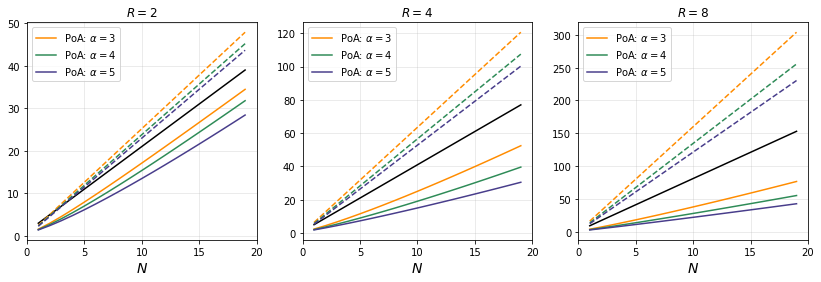

In [339]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['darkorange', 'seagreen', 'darkslateblue']
for i in range(3):
    axarr[i].plot(ns, 1+ns*rs[i], color='black')
    for j in range(3):
        axarr[i].plot(ns, poas[i,:,j], label=r'PoA: $\alpha=${}'.format(alphas[j]), color=colors[j])
        axarr[i].plot(ns, ns*(rs[i]**((alphas[j]+1)/alphas[j])), color=colors[j], linestyle='--')
#         axarr[i].plot(ns, welfares[i,:,j], label=r'Welfare loss: $\alpha=${}'.format(alphas[j]), 
#                       color=colors[j], linestyle='--')
    
for i, ax in enumerate(axarr):
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xlabel(r'$N$', size=14)
    ax.set_title(r'$R={}$'.format(rs[i], size=14))

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# equilibrium under R reserve bidding.

In [437]:
def getBoundedEquilBids(cs, a, R, guess=None):
    n = len(cs)
    bs_syms = [sp.Symbol(f'b{i}', positive=True) for i in range(n)]
    denom_sym = sum(b_sy**(-a) for b_sy in bs_syms)
    xs_sym = [b_sy**(-a)/denom_sym for b_sy in bs_syms]
    us_sym = [(bs_syms[i] - cs[i])* xs_sym[i] for i in range(n)]
    # partial derivatives
    diffs_sym = [sp.diff(us_sym[i], bs_syms[i]) for i in range(n)]
    
    # lambdify => numeric residual function
    diffs_funcs = [sp.lambdify(bs_syms, diffs_sym[i], 'numpy') for i in range(n)]
    
    def residual(b):  # R^n -> R^n
        return [diffs_funcs[i](*b) for i in range(n)]
    
    # bounds: we want 1 <= b_i <= R, or 0 < b_i <= R, up to you
    lb = np.ones(n)*1.0   # or zeros
    ub = np.ones(n)*R
    
    if guess is None:
        guess = np.ones(n)*(R+1)/2  # or something
    
    # call least_squares with method that supports bounds
    sol = least_squares(
        fun=residual, 
        x0=guess,
        bounds=(lb, ub),
        method='trf'  # or 'dogbox'
    )
    return sol.x

In [438]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [439]:
alpha = 3.
costs = [1, 2]

In [440]:
unbounded, bounded = getEquilBids(costs, alpha), getBoundedEquilBids(costs, alpha, R=3)
unbounded, bounded

(array([4.40546645, 4.83143957]), array([2.74046997, 3.        ]))

In [441]:
getAllos(unbounded, alpha), getAllos(bounded, alpha)

(array([0.56878482, 0.43121518]), array([0.5674485, 0.4325515]))

In [442]:
alpha = 3.
c1s   = np.arange(1, 50.01, 0.1)
c1s

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8,
       10.9, 11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9,
       12. , 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. ,
       13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1,
       14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2,
       15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16

In [443]:
guesses = c1s

ubb         = []
xTildes_ub  = []
welfares_ub = []  
for i, c1 in enumerate(c1s):
    costs  = [1, c1]
    bids   = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde = getAllos(bids, a=alpha)
    ubb.append(bids)
    xTildes_ub.append(xTilde)
    welfares_ub.append(np.dot(costs, xTilde))
ubb         = np.asarray(ubb)
xTildes_ub  = np.asarray(xTildes_ub)
welfares_ub = np.asarray(welfares_ub)
ubb.shape, xTildes.shape, welfares.shape

((491, 2), (191, 2), (191,))

In [444]:
bb          = []
xTildes_bb  = []
welfares_bb = []
for i, c1 in enumerate(c1s):
    costs  = [1, c1]
    bids   = getBoundedEquilBids(costs, a=alpha, R=c1+0.001, guess=[guesses[i],guesses[i]])
    xTilde = getAllos(bids, a=alpha)
    bb.append(bids)
    xTildes_bb.append(xTilde)
    welfares_bb.append(np.dot(costs, xTilde))
bb          = np.asarray(bb)
xTildes_bb  = np.asarray(xTildes_bb)
welfares_bb = np.asarray(welfares_bb)
bb.shape, xTildes_bb.shape, welfares_bb.shape

((491, 2), (491, 2), (491,))

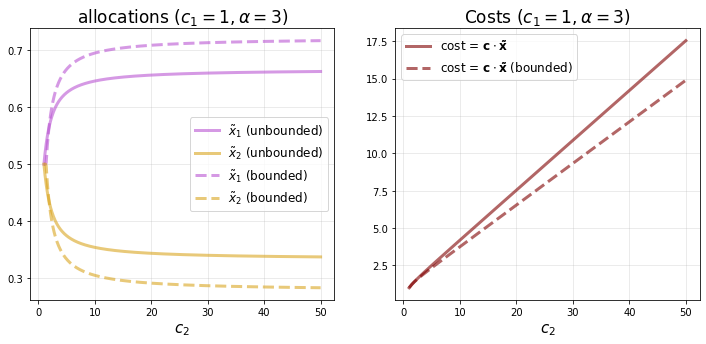

In [445]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xTildes_ub[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$ (unbounded)', color='mediumorchid',
              linestyle='-')
axarr[0].plot(c1s, xTildes_ub[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$ (unbounded)', color='goldenrod',
              linestyle='-')

axarr[0].plot(c1s, xTildes_bb[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$ (bounded)', color='mediumorchid',
              linestyle='--')
axarr[0].plot(c1s, xTildes_bb[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$ (bounded)', color='goldenrod',
              linestyle='--')

axarr[1].plot(c1s, welfares_ub, linewidth=3, alpha=0.6, color='maroon', 
              label=r'cost = $\mathbf{c} \cdot \mathbf{\tilde{x}}$')
# axarr[1].plot(c1s, ubb[:,0], linewidth=3, alpha=0.6, color='slateblue', label=r'$b_1$')
# axarr[1].plot(c1s, ubb[:,1], linewidth=3, alpha=0.6, color='forestgreen', label=r'$b_2$')

axarr[1].plot(c1s, welfares_bb, linewidth=3, alpha=0.6, color='maroon', 
              label=r'cost = $\mathbf{c} \cdot \mathbf{\tilde{x}}$ (bounded)', linestyle='--')
# axarr[1].plot(c1s, bb[:,0], linewidth=3, alpha=0.6, color='slateblue', label=r'$b_1$ (bounded)',
#               linestyle='--')
# axarr[1].plot(c1s, bb[:,1], linewidth=3, alpha=0.6, color='forestgreen', label=r'$b_2$ (bounded)',
#               linestyle='--')
# axarr[1].plot(c1s, c1s+0.1, linewidth=3, alpha=0.6, color='black', label=r'$y=x$',
#               linestyle='--')


for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
axarr[0].set_title(r'allocations $(c_1=1, \alpha=3)$', size=17)
axarr[1].set_title(r'Costs $(c_1=1, \alpha=3)$', size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# sympy for potential function

In [465]:
bi = sp.Symbol('b_i', positive=True)
ci = sp.Symbol('c_i', positive=True)
alpha = sp.Symbol('alpha', positive=True)
o = sp.Symbol('o', positive=True)

In [466]:
ui = (bi-ci)*bi**(-alpha) / (bi**(-alpha) + o)
ui

(b_i - c_i)/(b_i**alpha*(o + b_i**(-alpha)))

In [467]:
sp.diff(ui, bi)

-alpha*(b_i - c_i)/(b_i*b_i**alpha*(o + b_i**(-alpha))) + alpha*(b_i - c_i)/(b_i*b_i**(2*alpha)*(o + b_i**(-alpha))**2) + 1/(b_i**alpha*(o + b_i**(-alpha)))

In [468]:
xi = sp.Symbol('x_i', positive=True)

In [481]:
-alpha*xi*(bi-ci)/bi + alpha * xi**2 * (bi-ci)/bi + xi

alpha*x_i**2*(b_i - c_i)/b_i - alpha*x_i*(b_i - c_i)/b_i + x_i

In [488]:
alpha*xi**2 - alpha*xi**2 * (ci/bi) - alpha*xi +  alpha*xi *(ci/bi)+xi

alpha*x_i**2 - alpha*x_i - alpha*c_i*x_i**2/b_i + alpha*c_i*x_i/b_i + x_i

In [490]:
sp.Eq(xi*(alpha*xi-alpha+1), alpha*xi*ci/bi*(xi-1))

Eq(x_i*(alpha*x_i - alpha + 1), alpha*c_i*x_i*(x_i - 1)/b_i)

# Pranavs bound

In [677]:
def pranavbound(c, alpha):
    return 1/2 + (alpha - 2)/(2*alpha)*(1-1/(1+(alpha**2)/(2*(3*alpha-2))*c-1))

def pranavbound2(c, alpha):
    return 1/2+(.5-1/alpha)*(1-1/(1+alpha**2*(c-1)/(6*alpha-4)))

def pranavbound3(c, alpha):
    return 1/2 +(1/2-1/alpha)*(1-1/(1+(alpha**2/(2*(3*alpha-2)))*(c-1)))

In [678]:
pranavbound(10, 5), pranavbound2(10, 5), pranavbound3(10, 5)

(0.7687999999999999, 0.7689243027888446, 0.7689243027888446)

In [679]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [680]:
alpha = 5
c1s   = np.arange(1, 5.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. ])

In [673]:
guesses = c1s

xTildes  = []
welfares = [] 
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
xTildes.shape, welfares.shape

((41, 2), (41,))

In [674]:
def explicitQuadraticRoot(c, a):
    # Calculate coefficients
    A = (1 - c) * a**2 - 2 * a
    B = c * a * (a - 1) + 2 - a**2
    C = a - 1
    
    # Compute discriminant
    discriminant = B**2 - 4 * A * C
    
    # Compute square root of discriminant
    sqrt_discriminant = math.sqrt(discriminant)
    
    # Compute the positive root using the quadratic formula
    x_star = (-B - sqrt_discriminant) / (2 * A)
    
    return x_star

In [675]:
explicitQuadraticRoot(c=5, a=2.1)

0.516090215170903

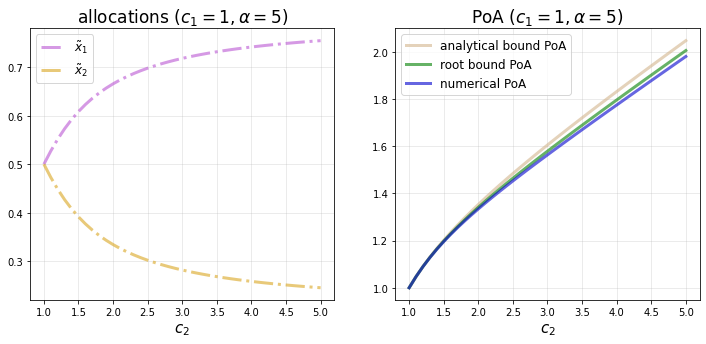

In [676]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')


# axarr[1].plot(c1s, pranavbound(c1s, alpha)+c1s*(1-pranavbound(c1s, alpha)), linewidth=3, alpha=0.6,
#               label='analytical bound PoA #1', color='green')
# axarr[1].plot(c1s, pranavbound2(c1s, alpha)+c1s*(1-pranavbound2(c1s, alpha)), linewidth=3, alpha=0.6,
#               label='analytical bound PoA #2', color='tan')

axarr[1].plot(c1s, pranavbound3(c1s, alpha)+c1s*(1-pranavbound3(c1s, alpha)), linewidth=3, alpha=0.6,
              label='analytical bound PoA', color='tan')
roots = np.array([explicitQuadraticRoot(c1, alpha) for c1 in c1s])

axarr[1].plot(c1s, roots+c1s*(1-roots), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')


for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha={})$'.format(alpha), size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# 3 player

In [690]:
alpha = 5
c1s   = np.arange(1, 5.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. ])

In [691]:
guesses = c1s*0.5

xTildes  = []
welfares = [] 
for i, c1 in enumerate(c1s):
    costs   = [1, c1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
xTildes.shape, welfares.shape

((41, 3), (41,))

In [696]:
def explicit3player(c, a):
    A = -2 * c * a**2 - (2 ** (1 + 1/a)) * (2 * a - a**2)
    B = -2 * c * a - (2 ** (1 + 1/a)) * (3 * a - 4)
    C = 2 * c * a * (a - 1) - (2 ** (1 + 1/a)) * (a**2 - 3 * a + 2)
    
    discriminant = B**2 - 4 * A * C    
    sqrt_discriminant = math.sqrt(discriminant)
    x1 = (-B + sqrt_discriminant) / (2 * A)
    x2 = (-B - sqrt_discriminant) / (2 * A)
    
    return x2

In [736]:
explicit3player(20, 3)

0.6497709950957203

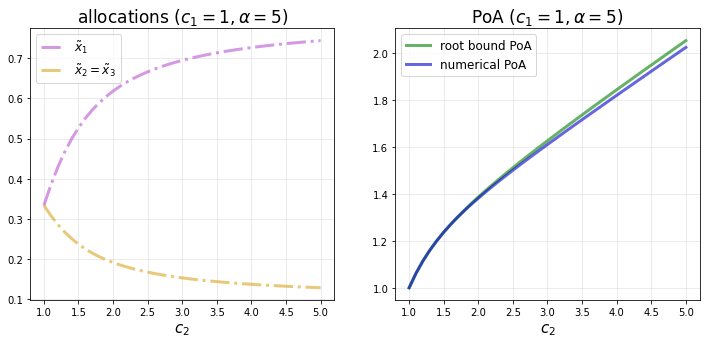

In [698]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2=\tilde{x}_3$', color='goldenrod',
              linestyle='-.')

roots = np.array([explicit3player(c1, alpha) for c1 in c1s])
axarr[1].plot(c1s, roots+c1s*(1-roots), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')


for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(c_1=1, \alpha={})$'.format(alpha), size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha={})$'.format(alpha), size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# N+1 player

In [832]:
alpha = 5
c1s   = np.arange(1, 5.01, 0.1)
c1s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. ])

In [844]:
N_ = 5
guesses = c1s / N_

xTildes  = []
welfares = [] 
for i, c1 in enumerate(c1s):
    costs   = [1]
    costs.extend([c1]*N_)
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i]]*(N_+1))
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
xTildes.shape, welfares.shape

((41, 6), (41,))

In [845]:
len(c1s), len(roots)

(41, 41)

In [846]:
# Define symbols
x, c, a, N = sp.symbols('x c a N')

# Define the original equation
lhs = c * (a - a*x - 1) / ((a*(N - 1))/N + (a*x)/N - 1)
rhs = (N**(1 + 1/a) * (a*(1 - x) + 2*x -1)) / (a*(N + x -1))

# Form the equation
equation = sp.Eq(lhs, rhs)
equation

Eq(c*(-a*x + a - 1)/(-1 + a*x/N + a*(N - 1)/N), N**(1 + 1/a)*(a*(1 - x) + 2*x - 1)/(a*(N + x - 1)))

In [847]:
quadratic_eq = sp.simplify(equation.lhs - equation.rhs)
quadratic_eq

(-N*a*c*(N + x - 1)*(a*x - a + 1) + N**((a + 1)/a)*(-N + a*x + a*(N - 1))*(a*(x - 1) - 2*x + 1))/(a*(-N + a*x + a*(N - 1))*(N + x - 1))

In [848]:
# Solve for x
roots_sym = sp.solve(quadratic_eq, x)
roots_sym[1]

(-N**2*a**2*c + 2*N*a**2*c - N*a*c - 2*N**(1 + 1/a)*a**2 + 3*N**(1 + 1/a)*a + N**(2 + 1/a)*a**2 - 3*N**(2 + 1/a)*a + 2*N**(2 + 1/a) + sqrt(N**4*a**4*c**2 - 2*N**3*a**3*c**2 + N**2*a**2*c**2 + 2*N**(2 + 1/a)*a**2*c + N**(2 + 2/a)*a**2 + 2*N**(3 + 1/a)*a**2*c - 4*N**(3 + 1/a)*a*c + 2*N**(3 + 2/a)*a**3 - 6*N**(3 + 2/a)*a**2 + 4*N**(3 + 2/a)*a - 2*N**(4 + 1/a)*a**4*c + 6*N**(4 + 1/a)*a**3*c - 4*N**(4 + 1/a)*a**2*c + N**(4 + 2/a)*a**4 - 6*N**(4 + 2/a)*a**3 + 13*N**(4 + 2/a)*a**2 - 12*N**(4 + 2/a)*a + 4*N**(4 + 2/a)))/(2*a*(N*a*c - N**(1 + 1/a)*a + 2*N**(1 + 1/a)))

In [849]:
sp.print_latex(roots_sym[1])

\frac{- N^{2} a^{2} c + 2 N a^{2} c - N a c - 2 N^{1 + \frac{1}{a}} a^{2} + 3 N^{1 + \frac{1}{a}} a + N^{2 + \frac{1}{a}} a^{2} - 3 N^{2 + \frac{1}{a}} a + 2 N^{2 + \frac{1}{a}} + \sqrt{N^{4} a^{4} c^{2} - 2 N^{3} a^{3} c^{2} + N^{2} a^{2} c^{2} + 2 N^{2 + \frac{1}{a}} a^{2} c + N^{2 + \frac{2}{a}} a^{2} + 2 N^{3 + \frac{1}{a}} a^{2} c - 4 N^{3 + \frac{1}{a}} a c + 2 N^{3 + \frac{2}{a}} a^{3} - 6 N^{3 + \frac{2}{a}} a^{2} + 4 N^{3 + \frac{2}{a}} a - 2 N^{4 + \frac{1}{a}} a^{4} c + 6 N^{4 + \frac{1}{a}} a^{3} c - 4 N^{4 + \frac{1}{a}} a^{2} c + N^{4 + \frac{2}{a}} a^{4} - 6 N^{4 + \frac{2}{a}} a^{3} + 13 N^{4 + \frac{2}{a}} a^{2} - 12 N^{4 + \frac{2}{a}} a + 4 N^{4 + \frac{2}{a}}}}{2 a \left(N a c - N^{1 + \frac{1}{a}} a + 2 N^{1 + \frac{1}{a}}\right)}


In [850]:
roots = np.array([roots_sym[1].evalf(subs={N:N_, a:alpha, c:c1}) for c1 in c1s])

In [863]:
def betterBound(c, a, N):
    num = c*a*(a*N-1) 
    den = N**(1+1/a)*(a-2)
    return num / den

In [866]:
betterBound(5, 3, 3)

27.734450974025393

In [864]:
test_bounds = np.array([betterBound(c1, alpha, N_) for c1 in c1s])

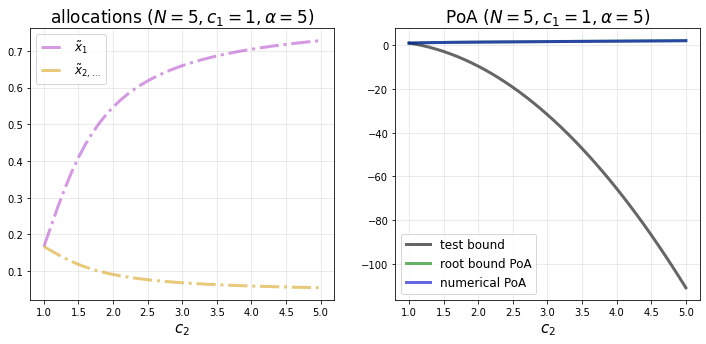

In [865]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_{2,\ldots}$', color='goldenrod',
              linestyle='-.')

axarr[1].plot(c1s, test_bounds+c1s*(1-test_bounds), linewidth=3, alpha=0.6,
              label='test bound', color='black')
axarr[1].plot(c1s, roots+c1s*(1-roots), linewidth=3, alpha=0.6,
              label='root bound PoA', color='green')
axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6, label='numerical PoA', color='mediumblue')


for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
    ax.legend(prop={'size': 12})
#     ax.set_xlim(1,2)
axarr[0].set_title(r'allocations $(N={}, c_1=1, \alpha={})$'.format(N_, alpha), size=17)
axarr[1].set_title(r'PoA $(N={}, c_1=1, \alpha={})$'.format(N_, alpha), size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# sympy

In [824]:
# Define symbols
x, c, a, N = sp.symbols('x c a N')

# Define the original equation
lhs = c * (a - a*x - 1) / ((a*(N - 1))/N + (a*x)/N - 1)
rhs = (N**(1 + 1/a) * (a*(1 - x) + 2*x -1)) / (a*(N + x -1))

# Form the equation
equation = sp.Eq(lhs, rhs)
equation

Eq(c*(-a*x + a - 1)/(-1 + a*x/N + a*(N - 1)/N), N**(1 + 1/a)*(a*(1 - x) + 2*x - 1)/(a*(N + x - 1)))

In [825]:
quadratic_eq = sp.simplify(equation.lhs - equation.rhs)
quadratic_eq

(-N*a*c*(N + x - 1)*(a*x - a + 1) + N**((a + 1)/a)*(-N + a*x + a*(N - 1))*(a*(x - 1) - 2*x + 1))/(a*(-N + a*x + a*(N - 1))*(N + x - 1))

In [827]:
# Solve for x
roots_sym = sp.solve(quadratic_eq, x)
roots_sym[1]

(-N**2*a**2*c + 2*N*a**2*c - N*a*c - 2*N**(1 + 1/a)*a**2 + 3*N**(1 + 1/a)*a + N**(2 + 1/a)*a**2 - 3*N**(2 + 1/a)*a + 2*N**(2 + 1/a) + sqrt(N**4*a**4*c**2 - 2*N**3*a**3*c**2 + N**2*a**2*c**2 + 2*N**(2 + 1/a)*a**2*c + N**(2 + 2/a)*a**2 + 2*N**(3 + 1/a)*a**2*c - 4*N**(3 + 1/a)*a*c + 2*N**(3 + 2/a)*a**3 - 6*N**(3 + 2/a)*a**2 + 4*N**(3 + 2/a)*a - 2*N**(4 + 1/a)*a**4*c + 6*N**(4 + 1/a)*a**3*c - 4*N**(4 + 1/a)*a**2*c + N**(4 + 2/a)*a**4 - 6*N**(4 + 2/a)*a**3 + 13*N**(4 + 2/a)*a**2 - 12*N**(4 + 2/a)*a + 4*N**(4 + 2/a)))/(2*a*(N*a*c - N**(1 + 1/a)*a + 2*N**(1 + 1/a)))

In [828]:
sp.print_latex(roots_sym[1])

\frac{- N^{2} a^{2} c + 2 N a^{2} c - N a c - 2 N^{1 + \frac{1}{a}} a^{2} + 3 N^{1 + \frac{1}{a}} a + N^{2 + \frac{1}{a}} a^{2} - 3 N^{2 + \frac{1}{a}} a + 2 N^{2 + \frac{1}{a}} + \sqrt{N^{4} a^{4} c^{2} - 2 N^{3} a^{3} c^{2} + N^{2} a^{2} c^{2} + 2 N^{2 + \frac{1}{a}} a^{2} c + N^{2 + \frac{2}{a}} a^{2} + 2 N^{3 + \frac{1}{a}} a^{2} c - 4 N^{3 + \frac{1}{a}} a c + 2 N^{3 + \frac{2}{a}} a^{3} - 6 N^{3 + \frac{2}{a}} a^{2} + 4 N^{3 + \frac{2}{a}} a - 2 N^{4 + \frac{1}{a}} a^{4} c + 6 N^{4 + \frac{1}{a}} a^{3} c - 4 N^{4 + \frac{1}{a}} a^{2} c + N^{4 + \frac{2}{a}} a^{4} - 6 N^{4 + \frac{2}{a}} a^{3} + 13 N^{4 + \frac{2}{a}} a^{2} - 12 N^{4 + \frac{2}{a}} a + 4 N^{4 + \frac{2}{a}}}}{2 a \left(N a c - N^{1 + \frac{1}{a}} a + 2 N^{1 + \frac{1}{a}}\right)}


In [831]:
roots_sym[1].evalf(subs={N:2, a:4, c:4})

0.662986655636080

In [830]:
explicit3player(c=4, a=4)

0.6629866556360797

In [867]:
from sympy import symbols, Eq, solve, simplify, pprint

# Define the symbols used in the equation
c_i, a, K, x_i = symbols('c_i a K x_i')

# Define the quadratic equation
quadratic_eq = Eq(
    c_i * x_i**2 + (c_i * (a - 2) - K * a) * x_i + (K * (a - 1) - c_i * (a - 1)),
    0
)

# Display the equation
print("Quadratic Equation:")
pprint(quadratic_eq)

# Solve the quadratic equation for x_i
solutions = solve(quadratic_eq, x_i)

# Simplify the solutions if possible
simplified_solutions = [simplify(sol) for sol in solutions]

Quadratic Equation:
                 2                                          
K⋅(a - 1) + cᵢ⋅xᵢ  - cᵢ⋅(a - 1) + xᵢ⋅(-K⋅a + cᵢ⋅(a - 2)) = 0


In [870]:
simplified_solutions[1]

(K*a - a*c_i + 2*c_i + sqrt(K**2*a**2 - 2*K*a**2*c_i + 4*K*c_i + a**2*c_i**2))/(2*c_i)

In [893]:
a, x1, x2, c1, c2, K = symbols('a x1 x2 c1 c2 K')
eq1 = Eq(c1 * x1**2 + (c1 * (a - 2) - K * a) * x1 + (K * (a - 1) - c1 * (a - 1)), 0)
eq1

Eq(K*(a - 1) + c1*x1**2 - c1*(a - 1) + x1*(-K*a + c1*(a - 2)), 0)

In [894]:
sols = solve([eq1], (x1))

In [896]:
sols[0][0]

-(-K*a + a*c1 - 2*c1)/(2*c1) - sqrt(K**2*a**2 - 2*K*a**2*c1 + 4*K*c1 + a**2*c1**2)/(2*c1)

In [880]:
from sympy import symbols, Eq, solve, simplify, pprint, sqrt

# Define symbols
x1, x2, c1, c2, K = symbols('x1 x2 c1 c2 K')

# Define parameters
a = 3

# Define equations
eq1 = Eq(c1 * x1**2 + (c1 * (a - 2) - K * a) * x1 + (K * (a - 1) - c1 * (a - 1)), 0)
eq2 = Eq(c2 * x2**2 + (c2 * (a - 2) - K * a) * x2 + (K * (a - 1) - c2 * (a - 1)), 0)
eq3 = Eq(x1 + x2, 1)

# Solve the system
solutions = solve([eq1, eq2, eq3], (x1, x2, K), dict=True)

KeyboardInterrupt: 

In [878]:
solutions[1]

{K: 354/125 - 6*sqrt(481)/125,
 x1: 9/50 - sqrt(481)/50,
 x2: sqrt(481)/50 + 41/50}

In [436]:
# SOFTMAX ALLO

In [536]:
def getEquilBidsSoftmax(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([sp.exp(-bi) for bi in bs])
    xs    = [sp.exp(-bi)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [568]:
costs = [1, 100]

n = 2
bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]

denom = sum([sp.exp(-bi) for bi in bs])
xs    = [sp.exp(-bi)/denom for bi in bs]
us    = [(bs[i] - costs[i])*xs[i] for i in range(n)]
diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
us[0]

(b0 - 1)*exp(-b0)/(exp(-b1) + exp(-b0))

In [571]:
sp.solve(diffs, bs)

NotImplementedError: could not solve (b1 - 100)*(exp(b1) + exp(LambertW(exp(b1 - 2)) + 2))*exp(3*b1)*exp(2*LambertW(exp(b1 - 2)) + 4) + (-(b1 - 100)*exp(b1)*exp(LambertW(exp(b1 - 2)) + 2) + exp(b1)*exp(LambertW(exp(b1 - 2)) + 2))*(exp(b1) + exp(LambertW(exp(b1 - 2)) + 2))**2*exp(2*b1)

In [567]:
def eqs(bs):
    return [f(*bs) for f in funcs]

fsolve(eqs, [10,10,10,10])

array([  3., 101., 101.,   3.])

In [565]:
costs = [1, 3]

unbounded = getEquilBids(costs, alpha)
unbounded

array([4.02964575, 4.7964842 ])

In [ ]:
alpha = 3.
c1s   = np.arange(1, 20.01, 0.1)
c1s

guesses = c1s

xTildes  = []
welfares = [] 
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
xTildes.shape, welfares.shape

In [303]:
import sympy as sp

# Define symbols
b0 = sp.Symbol('b0', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)
R = sp.Symbol('R', positive=True)

# For short-hand: M = N*R^(-alpha)
M = N * R**(-alpha)

# Define f(b0) = (b0 -1)* b0^(-alpha)
f_b0 = (b0 - 1)* b0**(-alpha)

# Define g(b0) = b0^(-alpha) + N R^(-alpha) = b0^(-alpha)+ M
g_b0 = b0**(-alpha) + M

# f'(b0), g'(b0)
fprime_b0 = sp.diff(f_b0, b0)
gprime_b0 = sp.diff(g_b0, b0)

# Derivative numerator => zero => FOC
# numerator = f'(b0)*g(b0) - f(b0)*g'(b0)
numerator = fprime_b0*g_b0 - f_b0*gprime_b0

# We want numerator=0

# -----------------------------
#  Substitutions:
#   1) x = b0^(-alpha)
#   2) y = x^(1/alpha) = b0^(-alpha * 1/alpha)= b0^-1 => b0=1/y
#
# We'll do it in two steps to avoid expressions with x^(1/alpha).

x = sp.Symbol('x', positive=True)
y = sp.Symbol('y', positive=True)

# Step A: Replace b0^(-alpha) with x in the numerator
eq_in_x = numerator.subs( b0**(-alpha), x )

# But eq_in_x still has b0 in terms like (b0-1). We must also rewrite b0 => (x^(-1/alpha)).
# Instead let's do: b0 = 1/y, so b0^(-alpha) = (1/y)^(-alpha)= y^alpha => x => y^alpha
#   => x= y^alpha,   b0=1/y

# So we want b0^(-alpha)-> x => that means x= y^alpha
# Also b0-> 1/y => we must do a final step eq_in_y= eq_in_x.subs({ b0:(1/y), x:y^alpha })

eq_in_x2 = eq_in_x.subs({ b0: 1/y })

# Now eq_in_x2 has x and y, but we want x= y^alpha => last substitution
eq_in_y = eq_in_x2.subs(x, y**alpha)

# eq_in_y is an expression purely in y, alpha, N, R, no b0 left.
# We'll solve eq_in_y=0 for y

# Let's simplify a bit:
eq_in_y_simpl = sp.simplify(eq_in_y)
eq_in_y_simpl

(y/R)**alpha*(N*alpha*y - N*alpha + N + (R*y)**alpha)

In [304]:
alpha

alpha

In [320]:
solutions_y = sp.solve(sp.Eq(eq_in_y_simpl.evalf(subs={alpha:4}), 0), y, dict=False)
1/solutions_y[0].evalf(subs={N:10, R: 10})

-3.97477821943946

In [322]:
import sympy as sp

# Symbolic variables
b0 = sp.Symbol('b0', positive=True)   # The best-response bid we want
N  = sp.Symbol('N',  positive=True)   # Number of high-cost players
R  = sp.Symbol('R',  positive=True)   # Reserve or cost
alpha = sp.Symbol('alpha', positive=True)  # Exponent alpha>1

# Define the payoff function for cost=1 player:
# u0(b0) = ((b0 -1)* b0^(-alpha)) / ( b0^(-alpha) + N * R^(-alpha) )
u0 = ((b0 - 1)* b0**(-alpha)) / (b0**(-alpha) + N*(R**(-alpha)))

# Derivative wrt b0
du0_db0 = sp.diff(u0, b0)

# Solve derivative=0 => best response ignoring constraints
solution_unconstrained = sp.solve(sp.Eq(du0_db0, 0), b0, dict=False)

print("Unconstrained symbolic solution(s) for b0^* with LambertW:\n")
for sol in solution_unconstrained:
    print(" b0^* =", sol)
    print("-----")


NotImplementedError: multiple generators [b0, b0**alpha]
No algorithms are implemented to solve equation -alpha*(b0 - 1)/(b0*b0**alpha*(N/R**alpha + b0**(-alpha))) + alpha*(b0 - 1)/(b0*b0**(2*alpha)*(N/R**alpha + b0**(-alpha))**2) + 1/(b0**alpha*(N/R**alpha + b0**(-alpha)))